In [ ]:
import os # Handle OS file systems and directory paths
import random # Random number
import numpy as np # Import NumPy for arrays and such
import matplotlib.pyplot as plt # Plotting Tools
import numpy.linalg as npl # Linear Algebra Library
import time # Time
# from google.colab import drive # Read files in from Google Drive
import pandas as pd # Import Pandas for data processing
import datetime as dt
import scipy.io as sio
import io
from decimal import Decimal # String to double conversion
from glob import glob  # 从 glob 模块中导入 glob 函数

In [34]:
import boto3
from botocore.exceptions import NoCredentialsError

In [35]:
# Optionally, you can specify the AWS region
s3 = boto3.client('s3', region_name='us-east-1')  # Replace 'us-west-2' with your AWS region

In [71]:
import pandas as pd
# s3_uri = 's3://pepper-dataset/crop_data/crop_IOWA/Iowa_corn_2019.csv'
# df = pd.read_csv(s3_uri)

In [37]:
df.shape

(425, 21)

In [38]:
# get county list
# county_path_list = glob('/content/drive/MyDrive/ai/era5/county_env/*')
# county_list = [os.path.basename(x) for x in county_path_list]
# print(county_list)

#Read files from s3
bucket_name = 'pepper-dataset'
prefix = 'county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/'

# List to store all object keys
county_files = []

# Initial call to list_objects_v2
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Process the initial response
while True:
    # Collect keys from current response
    current_keys = [obj['Key'] for obj in response.get('Contents', [])]
    county_files.extend(current_keys)

    # Check if there are more objects to retrieve
    if not response['IsTruncated']:
        break  # No more objects to retrieve

    # Get ContinuationToken for next paginated call
    continuation_token = response['NextContinuationToken']

    # Make subsequent call with ContinuationToken
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
    
    
county_files = ["/" + path if not path.startswith("/") else path for path in county_files]

In [39]:
len(county_files)

81217

In [40]:
county_files[:10]

['/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-01_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-01_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-02_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-02_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-03_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-03_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-04_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_feature

In [41]:
# try 1 county
year_range = [2015, 2020]
years = [x for x in range(year_range[0], year_range[-1]+1)]

filtered_files = [file_path for file_path in county_files
                  if any(str(year) in file_path for year in years)]

# basedir = '/content/drive/MyDrive/ai/era5/county_env/'
# county_files = []

# for c in county_list:
#   county = os.path.join(basedir, c)
#   print(county)

#   county_f = glob(os.path.join(county, '*'))

#   for f in county_f:
#     ym_str = f.split('_')[-2]
#     ym_obj = dt.datetime.strptime(ym_str, '%Y-%m')
#     if ym_obj.year not in years:
#         continue
#     county_files.append(f)

print(len(filtered_files))

  # print(len(county_files))
  # print(county_files[:3])

# get year-month info for the county
# ym_list = [x.split('_')[-2] for x in county_files]
# ym_list = list(set(ym_list))
# ym_list.sort()
# print(ym_list)

filtered_files[:50]


20304


['/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-01_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-01_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-02_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-02_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-03_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-03_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-04_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-04_part2.csv',
 '/county-env-da

In [42]:
pd.read_csv('s3://'+bucket_name+filtered_files[0])

,t2m,rsn,sde,stl1,stl2,stl3,stl4,tsn,swvl1,swvl2,swvl3,swvl4,datetime
0,1010.666667,-25195.800000,-32766.0,-7531.800000,-1533.400000,400.333333,1179.266667,25135.733333,5722.333333,6580.800000,2787.333333,6270.933333,2015-01-01 00:00:00
1,455.466667,-25021.000000,-32766.0,-8140.733333,-1605.466667,371.333333,1169.466667,23691.400000,5717.800000,6567.200000,2790.933333,6270.866667,2015-01-01 01:00:00
2,388.666667,-24844.133333,-32766.0,-8397.533333,-1692.266667,342.333333,1161.333333,24787.133333,5715.333333,6553.533333,2794.666667,6270.866667,2015-01-01 02:00:00
3,471.066667,-24659.066667,-32766.0,-8472.133333,-1779.266667,312.866667,1153.800000,26445.200000,5710.933333,6540.066667,2798.600000,6270.733333,2015-01-01 03:00:00
4,506.000000,-24463.666667,-32766.0,-8487.200000,-1861.266667,282.333333,1144.266667,27897.533333,5705.333333,6526.333333,2802.133333,6270.733333,2015-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,7277.000000,-19673.133333,-32766.0,-2578.333333,1113.266667,-1741.266667,-5683.200000,32766.000000,2941.600000,4195.666667,6174.266667,6473.133333,2015-01-31 19:00:00
740,7357.933333,-19870.266667,-32766.0,-2443.533333,1259.066667,-1748.533333,-5688.600000,32766.000000,2917.600000,4183.666667,6170.533333,6473.333333,2015-01-31 20:00:00
741,7219.533333,-19863.000000,-32766.0,-2649.800000,1378.800000,-1754.866667,-5695.133333,32767.000000,2902.666667,4174.466667,6167.866667,6473.533333,2015-01-31 21:00:00
742,7216.266667,-20187.466667,-32766.0,-2680.533333,1487.400000,-1758.933333,-5699.533333,32766.000000,2888.133333,4165.733333,6165.333333,6473.533333,2015-01-31 22:00:00


In [154]:
df_list = pd.DataFrame(columns=("Year","State","County","Month","Commodity","Feature"))

for csvf in filtered_files:
    # only read part1, then match with part2
    if 'part2' in csvf:
        continue
    # print(csvf)
    crop = "UNKNOWN"

    suffix = csvf.split('/')[-1]
    state = suffix.split('_')[-4].upper()
    # print(state)
    if state != "MINNESOTA":
        continue
    county_name = suffix.split('_')[-3].upper()
    ym_str = csvf.split('_')[-2]

    year = int(suffix.split('-')[0][-4:])
    month = int(suffix.split('-')[1][:2])
    ym_obj = dt.datetime.strptime(ym_str, '%Y-%m')
    if ym_obj.year not in years:
        continue
    # else:
    #     print(ym_str)
        # pass

    df1 = pd.read_csv('s3://'+bucket_name+csvf)
    # df1.dropna(axis=1)
    csvf_part2 = csvf.replace('part1', 'part2')
    df2 = pd.read_csv('s3://'+bucket_name+csvf_part2)
    # df2.dropna(axis=1)


    df12 = pd.merge(df1, df2, on = 'datetime')
      # drop datetime
    df12 = df12.drop(columns=['datetime'])
    df12 = df12.drop(columns=['sshf'])
    df12 = df12.drop(columns=['evavt'])
    # df12.drop(columns=['datetime'])
    # print(df12.head())
    # print("size:", len(df12))
    # print(df12.dtype)

    # print("-----------------------")
    # print(df12.shape)
    row = [year,state,county_name,month,crop]
    row.append(df12)
    # print(row[:4])

    # df_list.append(df12)
    dfLength = len(df_list)
    df_list.loc[dfLength] = row

# df_all = df_list[0]
# for df in df_list[1:]:
#     df_all = pd.concat([df_all, df], axis = 0)

print("Number of Features Per County Per Year:  >= ",len(df_list.iloc[1,4]))
# print(df_list["State"])
# df_list['Feature'] = df_list['Feature'].astype(object)

# df_list.to_csv('/content/drive/MyDrive/ai/era5/dataSat_cleaned_Iowa_2015-2020.csv', index=False)

Number of Features Per County Per Year:  >=  7


In [155]:
df_list.iloc[1][-1].head()

,t2m,rsn,sde,stl1,stl2,stl3,stl4,tsn,swvl1,swvl2,swvl3,swvl4,evabs,sp,ssrd,strd,tp
0,-4742.533333,-21631.200000,-31912.866667,-13057.600000,-8738.266667,-14666.600000,-23634.266667,15699.000000,-9962.066667,-9733.866667,-11286.000000,-9725.666667,32597.066667,22801.800000,-10000.8,1682.6,-32765.600000
1,-5357.733333,-21629.133333,-31912.866667,-13176.800000,-8744.600000,-14667.133333,-23642.266667,15608.133333,-9967.000000,-9737.000000,-11285.800000,-9725.666667,32767.000000,22849.800000,-32766.0,-31958.4,-32766.000000
2,-5961.600000,-21633.333333,-31916.600000,-13328.866667,-8753.133333,-14666.933333,-23649.800000,15465.600000,-9972.266667,-9740.333333,-11285.200000,-9725.866667,32767.000000,22881.333333,-32766.0,-30306.6,-32763.200000
3,-6587.466667,-21659.200000,-31916.600000,-13613.266667,-8766.333333,-14667.066667,-23658.933333,15021.266667,-9977.333333,-9743.666667,-11284.600000,-9725.866667,32767.000000,22877.200000,-32766.0,-28598.2,-32753.666667
4,-7213.466667,-21701.333333,-31912.866667,-13993.866667,-8785.800000,-14666.466667,-23666.466667,14174.466667,-9982.466667,-9746.800000,-11284.333333,-9725.866667,32767.000000,22877.933333,-32766.0,-26918.2,-32739.800000


In [156]:
# sys.getsizeof(df_list) / 1024 / 1024  # Byte -> MB
print(df_list.shape)
grouped_data = df_list.groupby(['Year', 'State', 'County']).size().reset_index(name='Count')
print(grouped_data)

(3240, 6)
     Year      State      County  Count
0    2015  MINNESOTA      BENTON     12
1    2015  MINNESOTA   BIG STONE     12
2    2015  MINNESOTA  BLUE EARTH     12
3    2015  MINNESOTA       BROWN     12
4    2015  MINNESOTA      CARVER     12
5    2015  MINNESOTA     CHISAGO     12
6    2015  MINNESOTA  COTTONWOOD     12
7    2015  MINNESOTA      DAKOTA     12
8    2015  MINNESOTA       DODGE     12
9    2015  MINNESOTA   FARIBAULT     12
10   2015  MINNESOTA    FILLMORE     12
11   2015  MINNESOTA    FREEBORN     12
12   2015  MINNESOTA     GOODHUE     12
13   2015  MINNESOTA    HENNEPIN     12
14   2015  MINNESOTA     HOUSTON     12
15   2015  MINNESOTA     JACKSON     12
16   2015  MINNESOTA    LE SUEUR     12
17   2015  MINNESOTA        LYON     12
18   2015  MINNESOTA    MAHNOMEN     12
19   2015  MINNESOTA      MARTIN     12
20   2015  MINNESOTA      MCLEOD     12
21   2015  MINNESOTA    MORRISON     12
22   2015  MINNESOTA      MURRAY     12
23   2015  MINNESOTA    NICOLL

In [157]:
# read crop yield (cy) data
year_range = [2015, 2020]
years = [x for x in range(year_range[0], year_range[-1]+1)]

def is_convertible_to_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

# cy_file_list = glob('/content/drive/MyDrive/ai/crop_yield/*csv')
# print((cy_file_list))
bucket_name = 'pepper-dataset'
prefix = 'crop_data/crop_3/'

# List to store all object keys
cy_file_list = []

# Initial call to list_objects_v2
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Process the initial response
while True:
    # Collect keys from current response
    current_keys = [obj['Key'] for obj in response.get('Contents', [])]
    cy_file_list.extend(current_keys)

    # Check if there are more objects to retrieve
    if not response['IsTruncated']:
        break  # No more objects to retrieve

    # Get ContinuationToken for next paginated call
    continuation_token = response['NextContinuationToken']

    # Make subsequent call with ContinuationToken
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
    
cy_file_list = ["/" + path if not path.startswith("/") else path for path in cy_file_list]

print(cy_file_list)
cy_df_list = []
for cy_file in cy_file_list:
    suffix = cy_file.split('/')[-1]
    temp = suffix.split('_')
    state = temp[0].upper()
    
    if state == "MINNESOTA":
        crop_type = temp[1]
        df = pd.read_csv('s3://'+bucket_name+cy_file)
        df = df[(df['Year'] >= 2015) & (df['Year'] <= 2020)]
        # Drop Rows that do not have "YIELD" in the "DATA ITEM" column
        dataYield = df.drop(df[~df["Data Item"].str.contains("YIELD")].index, inplace = False)
        # Drop Rows that have "IRRIGATED" in the "DATA ITEM" column
        dataYield = dataYield.drop(dataYield[dataYield["Data Item"].str.contains("IRRIGATED")].index, inplace = False)
        cy_df_list.append(dataYield)
        
        
# for cy_file in cy_file_list:
#     suffix = cy_file.split('/')[-1]
#     year = suffix.split('.')[0].split('_')[-1]
#     print(year)
#     if is_convertible_to_int(year) and int(year) not in years:
#       continue

#     crop_type = cy_file.split('_')[-2]
#     df = pd.read_csv('s3://'+bucket_name+cy_file)

#     # Drop Rows that do not have "YIELD" in the "DATA ITEM" column
#     dataYield = df.drop(df[~df["Data Item"].str.contains("YIELD")].index, inplace = False)
#     # Drop Rows that have "IRRIGATED" in the "DATA ITEM" column
#     dataYield = dataYield.drop(dataYield[dataYield["Data Item"].str.contains("IRRIGATED")].index, inplace = False)
#     cy_df_list.append(dataYield)

cy_df_all = cy_df_list[0]
for df in cy_df_list[1:]:
    cy_df_all = pd.concat([cy_df_all, df], axis = 0)
print(cy_df_all.shape)

print(cy_df_all.head())




['/crop_data/crop_3/', '/crop_data/crop_3/Arkansas_corn_2000-2022.csv', '/crop_data/crop_3/Illinois_corn_2000-2022.csv', '/crop_data/crop_3/Iowa_corn_2000-2022.csv', '/crop_data/crop_3/Minnesota_corn_2000-2022.csv', '/crop_data/crop_3/NorthDakota_corn_2000-2022.csv', '/crop_data/crop_3/Ohio_corn_2000-2022.csv', '/crop_data/crop_3/Washington_corn_2000-2022.csv']
(606, 21)
    Program  Year Period  Week Ending Geo Level      State  State ANSI  \
848  SURVEY  2020   YEAR          NaN    COUNTY  MINNESOTA          27   
851  SURVEY  2020   YEAR          NaN    COUNTY  MINNESOTA          27   
855  SURVEY  2020   YEAR          NaN    COUNTY  MINNESOTA          27   
858  SURVEY  2020   YEAR          NaN    COUNTY  MINNESOTA          27   
862  SURVEY  2020   YEAR          NaN    COUNTY  MINNESOTA          27   

    Ag District  Ag District Code          County  County ANSI  Zip Code  \
848         NaN                99  OTHER COUNTIES          NaN       NaN   
851         NaN              

In [158]:
dataROI = cy_df_all[["Year","State","County","Commodity","Value"]]
name_year = dataROI["Year"].drop_duplicates()
name_states = dataROI["State"].drop_duplicates()
name_county = dataROI["County"].drop_duplicates()
name_crops = dataROI["Commodity"].drop_duplicates()

dfOut = pd.DataFrame(columns=("Year","State","County","Commodity","Yield"))

# For each year
idx = 0
for year in name_year:
  temp_year = dataROI.loc[dataROI["Year"]==year]
  # if debug and verbose: print(temp_year)
  # For each state
  for state in name_states:
    temp_state = temp_year.loc[temp_year["State"]==state]
    # if debug and verbose: print(temp_state)
    # For each county
    for county in name_county:
      temp_county = temp_state.loc[temp_state["County"]==county]
      # if debug and verbose: print(temp_county)
      # For each crop
      for crop in name_crops:
        temp_crops = temp_county.loc[temp_county["Commodity"]==crop]
        # if debug and verbose: print(temp_crops)
        crop_yield = temp_crops["Value"]
        crop_yield = crop_yield.replace(',','', regex=True)
        crop_yield = pd.to_numeric(crop_yield)
        crop_yield = crop_yield.sum()
        # if debug and verbose: print(crop_yield)

        # Add to Output Data Frame
        dfOut.loc[idx] = [year,state,county,crop,crop_yield]

        # Increment idx
        idx = idx + 1

print(dfOut.head())
# wheat_rows = dfOut[dfOut['Commodity'] == 'WHEAT']
# print("wheat_rows: ", len(wheat_rows))
dfOut

   Year      State          County Commodity  Yield
0  2020  MINNESOTA  OTHER COUNTIES      CORN  217.8
1  2020  MINNESOTA          BENTON      CORN  207.7
2  2020  MINNESOTA          CARVER      CORN  223.6
3  2020  MINNESOTA       KANDIYOHI      CORN  218.7
4  2020  MINNESOTA          MCLEOD      CORN  184.7


,Year,State,County,Commodity,Yield
0,2020,MINNESOTA,OTHER COUNTIES,CORN,217.8
1,2020,MINNESOTA,BENTON,CORN,207.7
2,2020,MINNESOTA,CARVER,CORN,223.6
3,2020,MINNESOTA,KANDIYOHI,CORN,218.7
4,2020,MINNESOTA,MCLEOD,CORN,184.7
5,2020,MINNESOTA,MEEKER,CORN,213.8
6,2020,MINNESOTA,MORRISON,CORN,197.7
7,2020,MINNESOTA,RENVILLE,CORN,198.4
8,2020,MINNESOTA,SCOTT,CORN,221.3
9,2020,MINNESOTA,SHERBURNE,CORN,201.4


In [159]:
def runCorrelateFeatureLabel(dataLabel,dataFeature,crop="WHEAT",dropZeroYield=True,debug=False,verbose=False):
  """Takes 2 pandas DataFrames (Label & Feature) and pairs them together"""

  # Drop Rows without the Desired Crop
  # print("pre dataCrop:", dataLabel.head())
  dataCrop = dataLabel.drop(dataLabel[~dataLabel["Commodity"].str.contains("CORN")].index, inplace = False)
  print("pre2 dataCrop:", dataCrop.head())
  dataCrop = dataCrop.drop(columns=["Commodity"]) #TODO: Assume we are only using 1 commodity
  dataFeat = dataFeature.drop(columns=["Commodity"])
  print("dataCrop:", dataCrop.head())
  print("dataFeat:", dataFeat.head())
  # print("++++++++++++++++++")

  # Merge DataFrames
  # Ref: https://realpython.com/pandas-merge-join-and-concat/
  # dataCrop.index = dataCrop.index.astype('object')
  print("------1: ", dataCrop.dtypes)
  print("------2: ", dataFeat.dtypes)
  dataFeat['Year'] = dataFeat['Year'].astype('int64')
  dataMerge = dataCrop.merge(dataFeat,how='right',on=['Year','State','County'])
  print(dataMerge.head())

  # Drop Rows without yield information
  if dropZeroYield:
    dataOut = dataMerge.drop(dataMerge[dataMerge["Yield"]==0.0].index,inplace=False)
  else:
    dataOut = dataMerge

  # Drop Rows with NaN
  dataOut.dropna(subset=['Yield'],inplace=True)

  if debug: print(dataOut)

  return dataOut

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# print("row shape:", df_list.iloc[1][4].info())
print(dfOut.shape)
print(dfOut.head())
print(df_list.shape)
print(df_list.head())
print(df_list.iloc[1][5].shape)
print("---------------------+")
# print(df_list.iloc[1])
dataSet = runCorrelateFeatureLabel(dfOut,df_list,crop="CORN",dropZeroYield=True,debug=False)

print("------------------")
print(dataSet.shape)
print(dataSet.head())



(504, 5)
   Year      State          County Commodity  Yield
0  2020  MINNESOTA  OTHER COUNTIES      CORN  217.8
1  2020  MINNESOTA          BENTON      CORN  207.7
2  2020  MINNESOTA          CARVER      CORN  223.6
3  2020  MINNESOTA       KANDIYOHI      CORN  218.7
4  2020  MINNESOTA          MCLEOD      CORN  184.7
(3240, 6)
   Year      State  County  Month Commodity  \
0  2015  MINNESOTA  BENTON      1   UNKNOWN   
1  2015  MINNESOTA  BENTON      2   UNKNOWN   
2  2015  MINNESOTA  BENTON      3   UNKNOWN   
3  2015  MINNESOTA  BENTON      4   UNKNOWN   
4  2015  MINNESOTA  BENTON      5   UNKNOWN   

                                             Feature  
0                t2m           rsn           sde ...  
1                t2m           rsn           sde ...  
2                t2m           rsn           sde ...  
3                t2m           rsn           sde ...  
4                t2m           rsn      sde      ...  
(672, 17)
---------------------+
pre2 dataCrop:    Year 

In [160]:
def saveCorrelatedData(data,savePath,saveName,debug=False):
  """Save the correlated data to a mat for easier processing"""

  # Extract from DataFrame as list
  feature = data['Feature']
  print("feature len: ", len(feature))
  label = data['Yield']
  print("label len: ", len(label))
  # print(label)
  month = data['Month']
  if debug: print(len(feature))

  feat_lst = []
  label_lst = []
  firstTimeLoop = True
  for idx in range(len(feature)):
    # if debug: print(idx)
    print("idx:", idx)
    if int(month.iloc[idx]) == 1:
      feat_new = []
    for f in feature.iloc[idx]:
      # print(f)
      # feat_new.append(feature.iloc[idx][f])
      for item in feature.iloc[idx][f]:
        feat_new.append(item)
    # feat_new = np.array(feat_new)

    # Drop Bad Datasets
    # if len(feat_new) != 20: #4320: for whole year, 2520 for Jan-Jul, 3240 for Nov-Jul
    #   if debug: print("skipping feature of length",len(feat_new))
    #   continue

    if int(month.iloc[idx]) != 12:
      continue

    if len(feat_new) != 148920:  # 检查 feat_new 列表的长度是否为 240
        print("Skipping feature at index", idx, "due to incorrect length:", len(feat_new))
        continue

    print("feat_new len:", len(feat_new))
    # print("feat_arr:", len(feat_arr))
    # Append Features
    feat_lst.append(feat_new)
    label_lst.append(label.iloc[idx])

  print(len(label_lst))
  # feat_arr = np.array(feat_lst)
  feat_arr = feat_lst
  # print(feat_arr[0])

  data_feature_expanded = pd.DataFrame(feat_arr)

  # 将 DataFrame 写入 CSV 文件
  print("start writing dataFrame to csv: ", 's3://'+bucket_name+'/MINNESOTA_data_feature_expanded_CORN_cleaned.csv')
  data_feature_expanded.to_csv('s3://'+bucket_name+'/MINNESOTA_data_feature_expanded_CORN_cleaned.csv', index=False)

  print("Data successfully written to 'MINNESOTA data_feature_expanded.csv'")

  # Get Ready to Save
  # feature = feat_arr.tolist()
  label = label_lst
  data_label_expanded = pd.DataFrame(label)
  data_label_expanded.to_csv('s3://'+bucket_name+'/MINNESOTA_data_label_expanded_CORN_cleaned.csv', index=False)
  print("Data successfully written to 'MINNESOTA_data_label_expanded.csv'")

  # Save Path
  # saveFile = savePath + saveName
  # print("Saving to:",saveFile)
  # sio.savemat(saveFile, mdict={'feature': feat_arr, 'label': label})

  # df = pd.DataFrame(feat_arr)
  # df['label'] = label
  # filename = '/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.csv'

  # 将 DataFrame 写入 CSV 文件
  # df.to_csv(filename, index=False, header=False)
  print("++++++++++++")
  # print("feat_arr shape: ", feat_arr.shape)
  # print(feat_arr.head())
  print(len(feat_arr))
  print(len(feat_arr[0]))
  print(label)


  return label, feat_arr


# print(dataSet.iloc[1][4].shape())

label, feat_arr = saveCorrelatedData(dataSet,"/content/drive/MyDrive/ai/era5/","yield_Iowa_corn_noIrr.mat",debug=True)


feature len:  3240
label len:  3240
3240
idx: 0
idx: 1
idx: 2
idx: 3
idx: 4
idx: 5
idx: 6
idx: 7
idx: 8
idx: 9
idx: 10
idx: 11
feat_new len: 148920
idx: 12
idx: 13
idx: 14
idx: 15
idx: 16
idx: 17
idx: 18
idx: 19
idx: 20
idx: 21
idx: 22
idx: 23
Skipping feature at index 23 due to incorrect length: 149328
idx: 24
idx: 25
idx: 26
idx: 27
idx: 28
idx: 29
idx: 30
idx: 31
idx: 32
idx: 33
idx: 34
idx: 35
feat_new len: 148920
idx: 36
idx: 37
idx: 38
idx: 39
idx: 40
idx: 41
idx: 42
idx: 43
idx: 44
idx: 45
idx: 46
idx: 47
feat_new len: 148920
idx: 48
idx: 49
idx: 50
idx: 51
idx: 52
idx: 53
idx: 54
idx: 55
idx: 56
idx: 57
idx: 58
idx: 59
feat_new len: 148920
idx: 60
idx: 61
idx: 62
idx: 63
idx: 64
idx: 65
idx: 66
idx: 67
idx: 68
idx: 69
idx: 70
idx: 71
Skipping feature at index 71 due to incorrect length: 149328
idx: 72
idx: 73
idx: 74
idx: 75
idx: 76
idx: 77
idx: 78
idx: 79
idx: 80
idx: 81
idx: 82
idx: 83
feat_new len: 148920
idx: 84
idx: 85
idx: 86
idx: 87
idx: 88
idx: 89
idx: 90
idx: 91
idx: 9

In [108]:
feat_arr[0]

[1010.6666666666666,
 455.4666666666666,
 388.6666666666667,
 471.06666666666666,
 506.0,
 718.2666666666667,
 644.3333333333334,
 996.1333333333332,
 1229.4,
 1234.4,
 1355.3333333333333,
 1440.0,
 1476.0666666666666,
 1597.6,
 1776.7333333333331,
 2148.2,
 2760.266666666667,
 3099.2,
 2960.2,
 5128.4,
 4828.466666666666,
 4461.333333333333,
 4044.6,
 3531.866666666667,
 3146.8,
 2924.8,
 2751.266666666667,
 2661.8,
 2649.6666666666665,
 2683.4666666666667,
 2681.6,
 2722.6,
 2755.4,
 2804.6666666666665,
 2819.6,
 2836.4666666666667,
 2847.6,
 2915.4666666666667,
 3038.2,
 3182.8,
 3332.0666666666666,
 3505.9333333333334,
 3789.4,
 4969.6,
 5023.733333333334,
 5093.2,
 4935.933333333333,
 4732.333333333333,
 4608.666666666667,
 4621.0,
 4714.533333333334,
 4887.333333333333,
 5132.733333333334,
 5431.066666666667,
 5822.0,
 6782.533333333334,
 7508.266666666666,
 8492.466666666667,
 9547.0,
 10678.266666666666,
 12208.733333333334,
 13828.6,
 14733.8,
 14973.133333333331,
 15215.13333

In [109]:
# Helper Functions
def get_time_now_ms():
    """Returns the current time in milliseconds"""
    ts = time.time()
    ts = round(ts) * 1000
    return int(ts)

In [110]:
!pip install keras

In [111]:
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
import keras
from keras.layers import Dense, TimeDistributed
from keras.models import Sequential
# from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
import itertools

from keras.layers import LSTM, RepeatVector
# from keras.layers.convolutional import Conv1D,Conv2D
# from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from numpy import dstack,  hstack
import scipy.io as sio
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.model_selection import train_test_split


# data_mat = "/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.mat" #Name of File, may need to specify path
# data_dict = sio.loadmat(data_mat) #Load MAT as a python dictionary
# print(data_dict)


In [161]:
# data_feature = data_dict['feature'] #Extract Features
# data_feature = feat_arr
data_feature = pd.read_csv('s3://'+bucket_name+ '/MINNESOTA_data_feature_expanded_CORN_cleaned.csv')

# print('Data Feature Shape:',data_feature.shape) # Verify Shape
# print("feature len: ", len(data_feature[0][0]))
# data_label = data_dict['label'] #Extract Labels
# data_label = label
data_label = pd.read_csv('s3://'+bucket_name+ '/MINNESOTA_data_label_expanded_CORN_cleaned.csv')
# print('Data Label Shape:',data_label.shape) # Verify Shape

# print(data_label)
# c1 = ["dewpoint_temperature_2m", "temperature_2m", "soil_temperature_level_1","soil_temperature_level_2"
#       ,"soil_temperature_level_3","soil_temperature_level_4","snowfall","volumetric_soil_water_layer_1",
#       "volumetric_soil_water_layer_2","volumetric_soil_water_layer_3","volumetric_soil_water_layer_4",
#       "surface_net_solar_radiation","surface_net_solar_radiation1",
#       "total_evaporation","surface_pressure","total_precipitation"]

# c = ["dewpoint_temperature_2m", "temperature_2m", "soil_temperature_level_1","soil_temperature_level_2"
#                              ,"soil_temperature_level_3","soil_temperature_level_4","snowfall","volumetric_soil_water_layer_1",
#                               "volumetric_soil_water_layer_2","volumetric_soil_water_layer_3","volumetric_soil_water_layer_4",
#                               "surface_net_solar_radiation","surface_net_solar_radiation1",
#                               "total_evaporation","surface_pressure","total_precipitation"]*288



# 假设 data_feature 是一个 1*467 的 DataFrame，每个单元格是一个长度为 175200 的序列
# 构造一个示例 DataFrame（实际使用中应替换为你的 data_feature）
# data_feature = pd.DataFrame([[np.random.rand(175200) for _ in range(467)]])

# 将 DataFrame 转置
# data_feature_transposed = data_feature.T

# print("data_feature_transposed[0].tolist(): ", len(data_feature_transposed[0][0]))
# 展开每个单元格中的序列
# data_feature_expanded = pd.DataFrame(data_feature_transposed[0][0].tolist())

# 检查转换后的 DataFrame 形状
# print("Original shape:", data_feature.shape)
# print("Transformed shape:", data_feature_expanded.shape)


train_X = data_feature
train_y = data_label.T

train_X = np.nan_to_num(train_X)
train_y = np.nan_to_num(train_y)

print(train_X.shape)
print(train_y.shape)

x = np.asarray(train_X, dtype=np.float32)
y = np.asarray(train_y).flatten()

# Training/Validation split 67%, 33% split
data_feature, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(X_test.shape)
print(data_feature.shape)

(180, 148920)
(1, 180)
(60, 148920)
(120, 148920)


In [162]:
print(data_feature.shape)
print(data_label.shape)

(120, 148920)
(180, 1)


In [163]:
def dataReshape(dataIn,debug=True,runOnce=False):
  """Takes the 1D feature array and reshapes to 270x16"""
  print(dataIn.shape)

  dataOut = []
  for idx in range(len(dataIn)):
    dataTemp = dataIn[idx].reshape(7446, 20) #(216,15) 3240
    if debug: print(dataTemp.shape)
    dataOut.append(dataTemp)

    if runOnce: return -1

  return np.array(dataOut)

data_feature_rs = dataReshape(data_feature,debug=False,runOnce=False)
print(data_feature_rs.shape)

#Reshape test
X_test = dataReshape(X_test,debug=False,runOnce=False)
print(X_test.shape)

(120, 148920)
(120, 7446, 20)
(60, 148920)
(60, 7446, 20)


In [164]:
# Network Parameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
SHUFFLE_BUFFER_SIZE = 64

# Normalize Data
normalizer = Normalization(axis=-1)
normalizer.adapt(data_feature_rs)
data_feature_norm = normalizer(data_feature_rs)

# Normalize Test
normalizer = Normalization(axis=-1)
normalizer.adapt(X_test)
X_test_norm = normalizer(X_test)


# Split into train and test datasets
# Load the Data into a data loader
train_dataset = tf.data.Dataset.from_tensor_slices((data_feature_norm,y_train.T))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm,y_test.T)) #TODO: REPLACE WITH TEST DATASET
DATASET_SIZE = len(data_feature_norm)

# Shuffle & Batch the Datasets
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [165]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [166]:
# Build Network
visible = Input(shape= (7446, 20))# (270, 16))

filters1 = 80
filters2 = 64

''' 1 Dimensional Convolution Network'''
# #cnn = Dense(50, activation='relu')#(cnn)
# cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(visible)
# # cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(cnn)
# # cnn = Dropout(0.2)(cnn)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# # cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
# # cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
# # cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)
# cnn = Dense(16, activation='relu')(cnn)
# # cnn = LSTM(50)(cnn) #TODO: this is not quite right
# # define output 1
# output1 = Dense(1)(cnn)

# ##test
# cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)
# cnn = Dense(16, activation='relu')(cnn)
# output1 = Dense(1)(cnn)


# model  = Sequential()
# model.add(Conv1D(filters=filters1, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2,activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(16))
# model.add(LSTM(64,recurrent_dropout=0.1))
# model.add(Dense(4))
# model.add(Flatten())
# model.add(Dense(1,activation='linear'))


cnn1 = Conv1D(filters=80, kernel_size=2, activation='relu')(visible)
cnn1 = Dense(64)(cnn1)

cnn1 = MaxPooling1D(pool_size=128)(cnn1)

cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
cnn2 = Dense(64)(cnn2)

cnn2 = MaxPooling1D(pool_size=128)(cnn2)

cnn3 = Conv1D(filters=32, kernel_size=2, activation='relu')(visible)
cnn3 = Dense(64)(cnn3)
cnn3 = MaxPooling1D(pool_size=128)(cnn3)

cnn4 =Conv1D(filters=16, kernel_size=2,activation='relu')(visible)
cnn4 = Dense(64)(cnn4)
cnn4 = MaxPooling1D(pool_size=128)(cnn4)
merged = keras.layers.concatenate([cnn1, cnn2,  cnn3, cnn4], axis=2)
cnn = Dense(16)(merged)
# cnn = LSTM(128,recurrent_dropout=0.1)(cnn)
# cnn =Dense(4)(cnn)
cnn = Flatten()(cnn)
output1 =Dense(1,activation='linear')(cnn)


''' 1 Dimensional Convolution Network + LSTM'''
# cnn = Conv1D(filters=10, kernel_size=2, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# # cnn = Flatten()(cnn)
# # cnn = Dense(50, activation='relu')(cnn)
# cnn = LSTM(32)(cnn) #TODO: this is not quite right
# output1 = Dense(1)(cnn)

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.003,
#     decay_steps=1000,
#     decay_rate=0.9)
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# tie together
model = Model(inputs=visible, outputs=output1)

model.compile(optimizer='adam', loss='mse', metrics =['accuracy','mean_squared_error','mean_absolute_percentage_error',tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 7446, 20)]           0         []                            
                                                                                                  
 conv1d_24 (Conv1D)          (None, 7445, 80)             3280      ['input_7[0][0]']             
                                                                                                  
 conv1d_25 (Conv1D)          (None, 7445, 64)             2624      ['input_7[0][0]']             
                                                                                                  
 conv1d_26 (Conv1D)          (None, 7445, 32)             1312      ['input_7[0][0]']             
                                                                                            

Epoch 1/200
4/4 - 7s - loss: 33496.8086 - accuracy: 0.0000e+00 - mean_squared_error: 33496.8086 - mean_absolute_percentage_error: 97.5767 - root_mean_squared_error: 183.0213 - val_loss: 32211.4492 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 32211.4492 - val_mean_absolute_percentage_error: 94.1475 - val_root_mean_squared_error: 179.4755 - 7s/epoch - 2s/step
Epoch 2/200
4/4 - 4s - loss: 30096.7676 - accuracy: 0.0000e+00 - mean_squared_error: 30096.7676 - mean_absolute_percentage_error: 91.0177 - root_mean_squared_error: 173.4842 - val_loss: 28003.7285 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 28003.7285 - val_mean_absolute_percentage_error: 86.2021 - val_root_mean_squared_error: 167.3431 - 4s/epoch - 1s/step
Epoch 3/200
4/4 - 5s - loss: 25312.0742 - accuracy: 0.0000e+00 - mean_squared_error: 25312.0742 - mean_absolute_percentage_error: 82.9167 - root_mean_squared_error: 159.0977 - val_loss: 21698.8652 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 21698.8652 - v

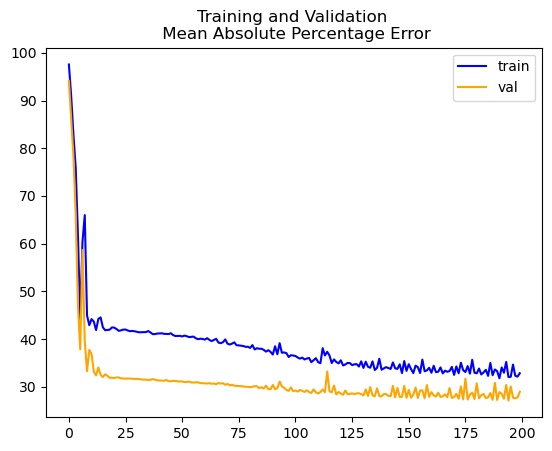

In [167]:
# FIT model with TRAINING DATA
history = model.fit(train_dataset, validation_data=test_dataset,epochs=NUM_EPOCHS,verbose=2)
model.summary()

# EVALUATE model with TESTING DATA
model.evaluate(test_dataset, verbose=0)

ynew = model.predict(test_dataset)
print(f'Test Loss: {ynew[0]}')
print(f'Test Mean Squared Error: {ynew[1]}')
print(f'Test Mean Absolute Percentage Error: {ynew[2]}')
print(f'Test Root Mean Squared Error: {ynew[3]}')

fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Absolute Percentage Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['mean_absolute_percentage_error'], color = 'blue', label = 'train')

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_mean_absolute_percentage_error'], color = 'orange', label = 'val')
ax.legend()

In [169]:
results = model.evaluate(test_dataset, batch_size=64)

2/2 [==============================] - 1s 349ms/step - loss: 961.3953 - accuracy: 0.0000e+00 - mean_squared_error: 961.3953 - mean_absolute_percentage_error: 28.9283 - root_mean_squared_error: 31.0064


In [170]:
import tensorflow as tf
import numpy as np

# 重置数据集
def create_test_dataset(X_test_norm, y_test):
    return tf.data.Dataset.from_tensor_slices((X_test_norm, y_test.T)).batch(64)

# 创建测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model with TESTING DATA
results = model.evaluate(test_dataset, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Mean Squared Error: {results[1]}')
print(f'Test Mean Absolute Percentage Error: {results[2]}')
print(f'Test Root Mean Squared Error: {results[3]}')

# PREDICT with TESTING DATA
ynew = model.predict(test_dataset)

# 重置测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model again with TESTING DATA
results = model.evaluate(test_dataset, batch_size=64)
print(f'loss: {results[0]} - accuracy: {results[1]} - mean_squared_error: {results[2]} - mean_absolute_percentage_error: {results[3]} - root_mean_squared_error: {results[4]}')


Test Loss: 961.3953247070312
Test Mean Squared Error: 0.0
Test Mean Absolute Percentage Error: 961.3953247070312
Test Root Mean Squared Error: 28.92827606201172
1/1 [==============================] - 1s 749ms/step - loss: 961.3953 - accuracy: 0.0000e+00 - mean_squared_error: 961.3953 - mean_absolute_percentage_error: 28.9283 - root_mean_squared_error: 31.0064
loss: 961.3953247070312 - accuracy: 0.0 - mean_squared_error: 961.3953247070312 - mean_absolute_percentage_error: 28.92827606201172 - root_mean_squared_error: 31.006376266479492


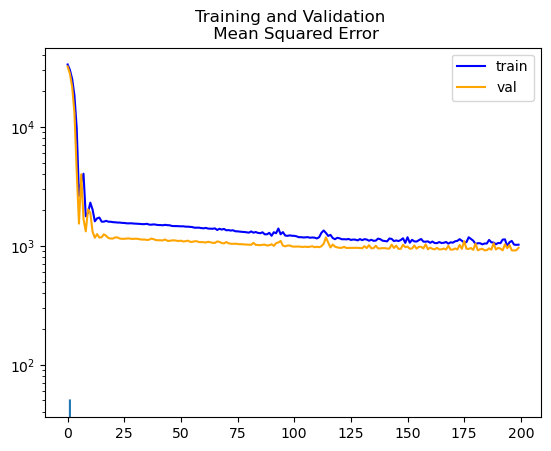

In [171]:
# plt.figure()
# plt.title('Loss (Mean Squared Error)')
# plt.plot(history.history['loss'])
# plt.figure()
# plt.title('Accuracy')
# plt.plot(history.history['accuracy'])
# plt.figure()
# plt.title('Mean Squared Error')
# plt.plot(history.history['mean_squared_error'])
# plt.figure()
fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Squared Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['loss'], color = 'blue', label = 'train')
# plt.figure()
## Validation Plots
# plt.title('Validation Loss (MSE)') # loss = 100 * abs(y_true - y_pred) / y_true
# plt.plot(history.history['val_loss'])
# plt.figure()

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_loss'], color = 'orange', label = 'val')
ax.semilogy((0,50))
ax.legend()
# plt.figure()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import numpy as np

y_pred = model.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 270, 16), found shape=(None, 8760, 19)
